# Прогнозирование оттока клиентов в сети отелей

Нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

Основная бизнес-метрика для любой сети отелей — её прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца. В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня. Стоимость номеров отеля:

категория A: за ночь — 1 000, разовое обслуживание — 400;  
категория B: за ночь — 800, разовое обслуживание — 350;  
категория C: за ночь — 600, разовое обслуживание — 350;  
категория D: за ночь — 550, разовое обслуживание — 150;  
категория E: за ночь — 500, разовое обслуживание — 150;  
категория F: за ночь — 450, разовое обслуживание — 150;  
категория G: за ночь — 350, разовое обслуживание — 150.  

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%. Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента. На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.


### Шаг 1. Откройте файлы с данными

In [1]:
!pip install scikit-learn --upgrade

     |████████████████████████████████| 12.2 MB 2.6 MB/s eta 0:00:01
     |████████████████████████████████| 302 kB 107.3 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 11111

In [3]:
data_train = pd.read_csv('/datasets/hotel_train.csv')
data_test = pd.read_csv('/datasets/hotel_test.csv')

In [4]:
def get_data_info(data):
    display(data.sample(5))
    display(data.info())
    display(data.describe(include='all'))

In [5]:
get_data_info(data_train)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
3246,3278,1,168.0,2016,April,16,12,0,2,2.0,...,0,0,0,A,0,0,Transient,0,0,2
32598,40538,1,220.0,2016,September,38,17,2,1,2.0,...,0,0,0,A,0,0,Transient-Party,0,0,3
2425,2446,1,3.0,2016,January,4,22,0,1,1.0,...,0,0,0,A,0,0,Transient-Party,0,2,1
62020,80714,0,183.0,2016,October,44,26,0,4,3.0,...,0,0,0,D,0,0,Transient,0,2,4
32732,40672,1,232.0,2016,September,39,20,0,4,2.0,...,0,0,0,A,0,0,Transient,0,1,4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

None

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000000,65229.000000,65229.000000,65229.000000,65229,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,...,65229.000000,65229.000000,65229.000000,65229,65229.000000,65229.000000,65229,65229.000000,65229.000000,65229.000000
unique,NaN,NaN,NaN,NaN,12,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,7,NaN,NaN,4,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,October,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,A,NaN,NaN,Transient,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,9255,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,50501,NaN,NaN,45493,NaN,NaN,NaN
mean,43544.069172,0.368609,96.337917,2015.719021,NaN,31.339772,15.847813,0.825185,2.224793,1.836576,...,0.027151,0.128915,0.107713,NaN,0.194269,3.334422,NaN,0.056647,0.512763,3.049978
std,25614.858971,0.482431,96.127545,0.449481,NaN,13.464024,8.748182,0.853477,1.354992,0.480245,...,0.162523,0.965326,1.326638,NaN,0.593838,18.239606,NaN,0.232094,0.752590,1.738108
min,0.000000,0.000000,0.000000,2015.000000,NaN,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,1.000000
25%,19108.000000,0.000000,17.000000,2015.000000,NaN,21.000000,8.000000,0.000000,1.000000,2.000000,...,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,2.000000
50%,40554.000000,0.000000,64.000000,2016.000000,NaN,34.000000,16.000000,1.000000,2.000000,2.000000,...,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,3.000000
75%,67414.000000,1.000000,151.000000,2016.000000,NaN,42.000000,23.000000,2.000000,3.000000,2.000000,...,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,1.000000,4.000000


In [6]:
data_test.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,...,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,...,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,...,0,0,0,A,0,0,Transient,0,0,7


In [7]:
get_data_info(data_test)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
1,6087,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
23593,89085,0,61.0,2017,April,14,6,0,3,2.0,...,0,0,0,A,0,0,Transient,0,1,3
17605,54794,1,308.0,2017,August,33,15,0,4,0.0,...,0,0,0,B,0,0,Transient,0,0,4
15541,52730,1,139.0,2017,June,25,21,0,3,3.0,...,0,0,0,E,0,0,Transient,0,2,3
8186,45375,1,55.0,2017,January,3,18,0,2,1.0,...,0,0,0,A,0,0,Transient,0,0,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

None

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
count,32412.000000,32412.000000,32412.000000,32412.0,32412,32412.000000,32412.000000,32412.000000,32412.00000,32412.000000,...,32412.000000,32412.000000,32412.000000,32412,32412.000000,32412.000000,32412,32412.000000,32412.000000,32412.000000
unique,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,7,NaN,NaN,4,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,May,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,A,NaN,NaN,Transient,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,5262,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,23471,NaN,NaN,27461,NaN,NaN,NaN
mean,60131.505183,0.388467,97.587869,2017.0,NaN,17.804054,15.656948,0.867888,2.34009,1.858602,...,0.031377,0.011601,0.171418,NaN,0.216741,0.262341,NaN,0.046248,0.657781,3.207979
std,29953.586177,0.487409,86.507146,0.0,NaN,9.177384,8.766429,0.853394,1.37517,0.489341,...,0.174338,0.180473,1.875170,NaN,0.640551,4.733027,NaN,0.219367,0.834341,1.738683
min,6086.000000,0.000000,0.000000,2017.0,NaN,1.000000,1.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,1.000000
25%,45291.750000,0.000000,23.000000,2017.0,NaN,10.000000,8.000000,0.000000,1.00000,2.000000,...,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,2.000000
50%,53394.500000,0.000000,76.000000,2017.0,NaN,18.000000,15.500000,1.000000,2.00000,2.000000,...,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,3.000000
75%,89800.250000,1.000000,155.000000,2017.0,NaN,25.000000,23.000000,2.000000,3.00000,2.000000,...,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,1.000000,4.000000


Данные открыты, пропусков в них нет, но стоит проверить данные с dtype  категории object на предмет дублей\ ошибок. И проверить категории с числовыми значеними на предмет выборосов и изучить как данные распределены

### Шаг 2. Предобработка и исследовательский анализ данных

In [8]:
data_train.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,0,0,0,A,0,0,Transient,0,1,3


Выделю катеогрии object-данных в отдельный список для удобства

In [9]:
cat_object_data =['arrival_date_month', 'meal', 'country', 'distribution_channel', 
                  'reserved_room_type', 'customer_type']

В столбце meal и reserved_room_type ненужные пробелы после названия, избавимся от них. (Из-за пропусков в meal задвоилась категория)

In [10]:
data_train['meal'] = data_train['meal'].str.strip()
data_train['reserved_room_type'] = data_train['reserved_room_type'].str.strip()

print(data_train['meal'].unique())
print(data_train['reserved_room_type'].unique())

['BB' 'FB' 'HB' 'SC']
['A' 'C' 'D' 'E' 'G' 'F' 'B']


Такая же история и в test данных, и еще обнаружилось, что не все месяцы попали в тестовую выборку. К сожалению, ничего с этим не сделать

In [11]:
data_test['meal'] = data_test['meal'].str.strip()
data_test['reserved_room_type'] = data_test['reserved_room_type'].str.strip()

print(data_train['meal'].unique())
print(data_train['reserved_room_type'].unique())

['BB' 'FB' 'HB' 'SC']
['A' 'C' 'D' 'E' 'G' 'F' 'B']


Построим гистаграммы по всем признакам:

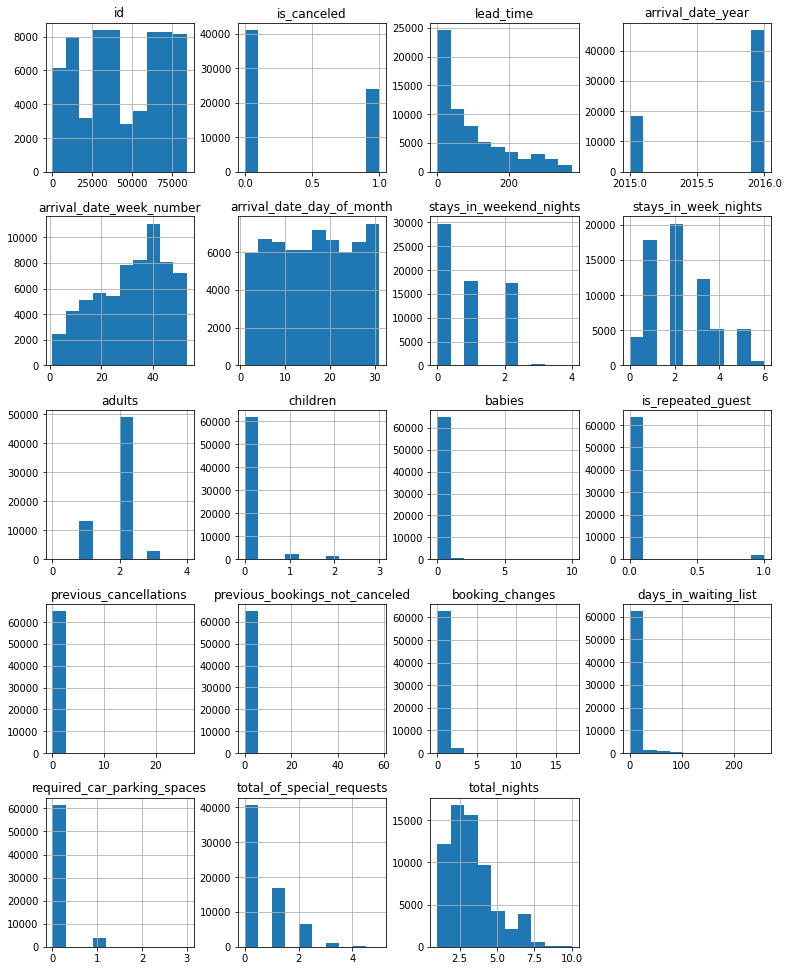

In [12]:
data_train.hist(figsize=(13,17));

Таргет для обучения модели - параметр is_canceled

В парамете lead_time  (датой можду бронированием заездом) и есть "хвост" с количеством дней, превышающих 200 дней. Но большинство заездов после брони в пределах 1-3 дней

Чаще всего бронируют 2 взрослых без детей (А возможно потому что такой предустановенный параметр стоит на сайте)
В параметре с младенцами есть какой-то выброс (со значением больше 10) просмотрю ниже, возможно удалим

Есть хвосты в previous_cancellations и previous_bookings_not_canceled, но ничего аномального там не обнаружил (ниже вывел выборки)
И также можно наблюдать хвост в days_in_waiting_list, мода тоже около нуля, но присутствуют и более редкие значения с высокомим значениями ( 50 и более дней)

In [13]:
data_train.query("babies > 2")

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
22995,30935,0,37.0,2016,January,3,12,0,2,2.0,...,0,0,0,D,1,0,Transient,0,1,2
41528,59925,0,11.0,2015,October,42,11,2,1,1.0,...,0,0,0,A,1,0,Transient-Party,0,0,3


2 записи с 9 и 10 младенцами. Не похоже на правду, лучше убрать эти данные. Тем более их 2 и на общую картину они не повлияют

In [14]:
data_train = data_train.query("babies < 2")

Проверим есть ли данные бронями, где есть дети, но нет взрослых:

In [15]:
data_train.query('(children > 0 | babies > 0) & adults == 0').shape[0]

151

151 запись- избавимся, так как дети без взрослых заселиться в отель точно не могут

In [16]:
data_train.drop(data_train.query('(children > 0 | babies > 0) & adults == 0').index, inplace=True)
data_test.drop(data_test.query('(children > 0 | babies > 0) & adults == 0').index, inplace=True)

Посмотрим на количество дней между датой бронирования и датой прибытия

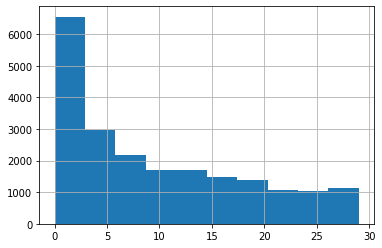

In [17]:
data_train['lead_time'][data_train['lead_time'] < 30].hist();


И на данные с подтвержденными и отмененными заказами

In [18]:
data_test[data_test['previous_bookings_not_canceled'] > 30]

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
18093,58131,0,0.0,2017,January,1,2,1,2,1.0,...,1,6,58,A,0,0,Transient,0,0,3
18094,58132,0,5.0,2017,January,2,10,0,3,1.0,...,1,6,59,A,0,0,Transient,0,2,3
18095,58133,0,0.0,2017,January,4,24,0,3,1.0,...,1,6,60,A,1,0,Transient,0,1,3
18096,58134,0,1.0,2017,January,5,31,0,3,1.0,...,1,6,61,A,0,0,Transient,0,1,3
18097,58135,0,4.0,2017,May,18,2,0,2,1.0,...,1,6,62,A,1,0,Transient,0,1,2
18098,58136,0,5.0,2017,May,19,8,1,2,1.0,...,1,6,63,A,0,0,Transient,0,1,3
18099,58137,0,6.0,2017,May,21,22,1,1,1.0,...,1,6,64,A,1,0,Transient,0,1,2
18100,58138,0,20.0,2017,June,23,6,0,3,1.0,...,1,6,65,A,1,0,Transient,0,1,3
18101,58139,0,4.0,2017,June,25,20,0,3,1.0,...,1,6,66,A,0,0,Transient,0,1,3
18102,58140,0,3.0,2017,June,26,26,1,3,1.0,...,1,6,67,A,1,0,Transient,0,1,4


In [19]:
data_test[data_test['previous_cancellations'] > 3]

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
2231,8697,0,134.0,2017,April,15,13,0,3,1.0,...,1,4,11,A,0,0,Transient,0,5,3
2232,8698,1,117.0,2017,April,15,13,0,3,1.0,...,1,4,11,A,0,0,Transient,0,4,3
2233,8699,0,125.0,2017,April,16,21,2,2,1.0,...,1,4,12,A,2,0,Transient,0,4,4
2234,8700,1,132.0,2017,April,17,28,1,2,1.0,...,1,4,13,A,0,0,Transient,0,4,3
2512,16061,0,2.0,2017,February,5,1,0,1,1.0,...,1,5,4,A,1,0,Transient,0,0,1
18093,58131,0,0.0,2017,January,1,2,1,2,1.0,...,1,6,58,A,0,0,Transient,0,0,3
18094,58132,0,5.0,2017,January,2,10,0,3,1.0,...,1,6,59,A,0,0,Transient,0,2,3
18095,58133,0,0.0,2017,January,4,24,0,3,1.0,...,1,6,60,A,1,0,Transient,0,1,3
18096,58134,0,1.0,2017,January,5,31,0,3,1.0,...,1,6,61,A,0,0,Transient,0,1,3
18097,58135,0,4.0,2017,May,18,2,0,2,1.0,...,1,6,62,A,1,0,Transient,0,1,2


<AxesSubplot:>

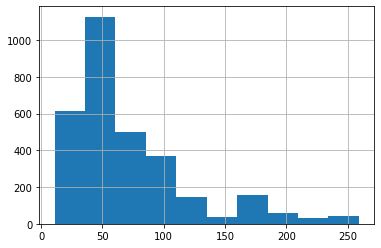

In [20]:
(data_train['days_in_waiting_list'][data_train['days_in_waiting_list'] > 10]).hist()

In [21]:
data_train['is_canceled'].value_counts()

0    41077
1    23996
Name: is_canceled, dtype: int64

Заранее посмотрим на таргет- наблюдаем дисбаланс, отмененных больше в 2 раза

In [22]:
data_train.country.value_counts()

PRT    28795
FRA     5959
GBR     5094
ESP     4888
DEU     3879
       ...  
RWA        1
STP        1
DMA        1
ABW        1
KNA        1
Name: country, Length: 155, dtype: int64

Есть довольно много стран, которые встречаются по 1 разу. Для удобства дальнейшей категоризации для ML думаю лучше объединить их в одну категорию (перебором количества стран вывел оптимально для себя число в 30), выберем эти данные

In [23]:
comb = pd.DataFrame(data_train.country.value_counts()).query('country <= 30').index 

comb2 = pd.DataFrame(data_test.country.value_counts()).query('country <= 30').index

Напишем функцию для объединиения таких стран в категорию Other

In [24]:
def change(row): 
    if row in comb or row in comb2:
        return 'OTHER'
    return row

In [25]:
data_train['country'] = data_train['country'].apply(change)
data_test['country'] = data_test['country'].apply(change)

In [26]:
data_train['country'].value_counts()

PRT      28795
FRA       5959
GBR       5094
ESP       4888
DEU       3879
ITA       2319
IRL       1442
OTHER     1343
BEL       1231
NLD       1159
BRA       1084
USA       1005
CHE        868
AUT        715
SWE        542
POL        529
CHN        525
CN         488
ISR        375
RUS        294
NOR        261
ROU        247
FIN        239
DNK        199
TUR        168
AUS        168
AGO        140
LUX        134
MAR        123
HUN        121
JPN        117
CZE        112
ARG        106
IND         87
GRC         81
KOR         67
HRV         54
MEX         43
ZAF         36
COL         36
Name: country, dtype: int64

Столбцов с данными стало намного меньше- при категоризации перед обучением модели не будет огромного количества столбцов

Проверим как коррелируют между собой признаки:

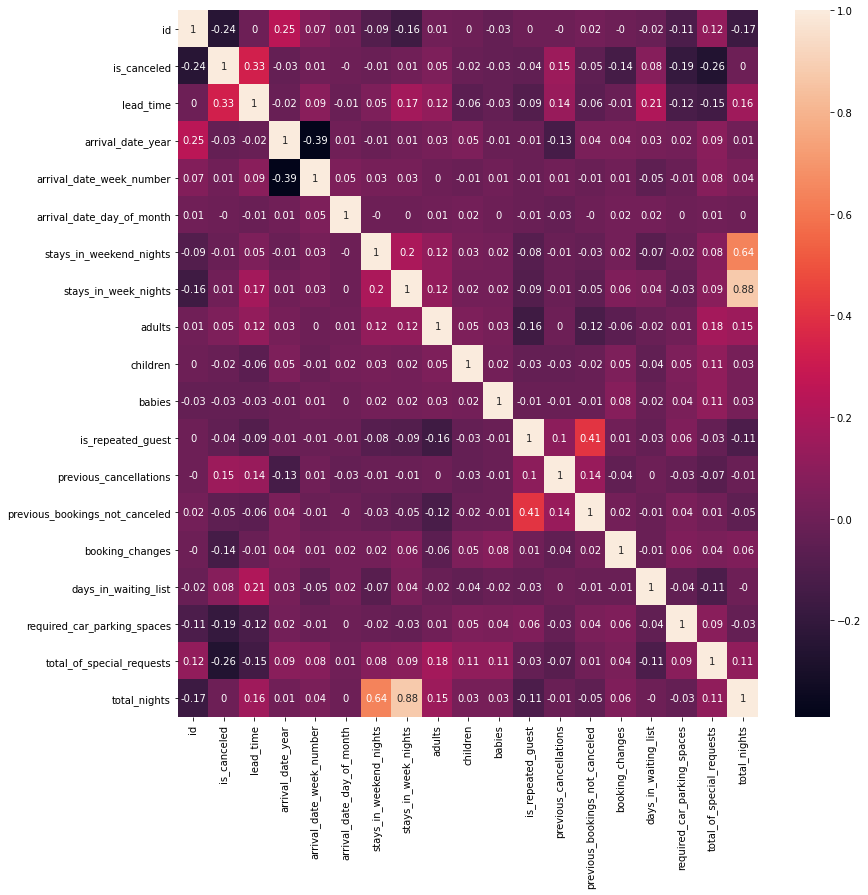

In [27]:
plt.rcParams['figure.figsize'] = (13, 13)
sns.heatmap(data_train.corr().round(2), annot=True);

Есть несколько параметров: stays_in_weekend_nights и stays_in_weekend_nights, которые достаточно сильно коррелируют с total_nights, но с другой стороны эти параметры вполне могут быть связаны друг с другом. 

In [28]:
data_train.duplicated().sum() #полных дубликатов нет

0

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

In [29]:
data_train.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,0,0,0,A,0,0,Transient,0,1,3


In [30]:
# пропишем константы

CATEGORY = {'A': 1000, 'B': 800, 'C': 600, 'D': 550, 'E': 500, 'F':450, 'G': 350}
ONE_TIME_A = 400
ONE_TIME_B_C = 350
ONE_TIME_OTHER = 150
COEF_SUMMER = 1.4
COEF_SPRING_AUTMN = 1.2


Создадим для удобства подсчета новый датафрейм с данными 

In [31]:
data_for_income = data_train[['is_canceled', 'arrival_date_month', 'reserved_room_type', 'total_nights']]
data_for_income.head()


,is_canceled,arrival_date_month,reserved_room_type,total_nights
0,0,July,A,1
1,0,July,A,2
2,0,July,C,2
3,0,July,C,2
4,1,July,A,3


Напишем промежуточные функции по определению коэффициентов, стоимости номера по категории, стоимости уборки

In [32]:
# Функция определения сезонного коэффициента

def coef(row):
    
    season = row['arrival_date_month']

    if season == 'December' or season == 'February' or season == 'January':
        return 1
    elif season == 'June' or season == 'July' or season == 'August':
        return COEF_SUMMER
    else:
        return COEF_SPRING_AUTMN



In [33]:
# определение цены комнаты

def room_price(row):
    
    return CATEGORY[row['reserved_room_type']]

In [34]:
# определение стоимости клининга

def cleaning(row):
    
    category = row['reserved_room_type']
    
    if category == 'A': 
        return ONE_TIME_A
    elif category == 'B' or category == 'C':
        return ONE_TIME_B_C
    else:
        return ONE_TIME_OTHER

И добавим в него новые столбцы, применяя написанные функции

In [35]:
data_for_income['season_coef'] = data_for_income.apply(coef, axis=1)
data_for_income['room_price'] = data_for_income.apply(room_price, axis=1)
data_for_income['cleaning_price'] = data_for_income.apply(cleaning, axis=1)
data_for_income.sample(5)

,is_canceled,arrival_date_month,reserved_room_type,total_nights,season_coef,room_price,cleaning_price
6551,0,October,A,1,1.2,1000,400
16233,0,December,A,3,1.0,1000,400
32818,1,September,A,2,1.2,1000,400
1554,0,October,E,7,1.2,500,150
8579,0,May,A,1,1.2,1000,400


Напишем функцию для подсчета прибыли без системы с депозитами :

In [36]:
def profit(row):
    if row['is_canceled'] == 0:
        return (row['room_price'] * 
                row['season_coef'] * 
                row['total_nights'] - 
                (1 + row['total_nights'] // 2) * 
                row['cleaning_price']
               )
    else:
        return - (row['room_price'] * row['season_coef'] + row['cleaning_price'])

In [37]:
data_for_income['profit'] = data_for_income.apply(profit, axis=1)

In [38]:
print(f'Суммарная прибыль отеля: {data_for_income["profit"].sum()}')

Суммарная прибыль отеля: 65984380.0


In [39]:
data_for_income.sample(5)

,is_canceled,arrival_date_month,reserved_room_type,total_nights,season_coef,room_price,cleaning_price,profit
8059,0,October,E,1,1.2,500,150,450.0
25228,1,April,D,6,1.2,550,150,-810.0
46069,0,February,A,1,1.0,1000,400,600.0
62782,0,November,D,1,1.2,550,150,510.0
64932,0,December,F,1,1.0,450,150,300.0


Из выборки видно, что попадаются записи с убытками

### Шаг 4. Разработка модели ML

Выделим из данных признаки для обучения и целевой признак, не будем выделять данные валидационные, применим кросс-валидацию

In [40]:
features_train = data_train.drop(['is_canceled'], axis=1)
target_train = data_train['is_canceled']
features_test = data_test.drop(['is_canceled'], axis=1)
target_test = data_test['is_canceled']

In [41]:
#удалю ненужный признак id
features_train = features_train.drop(['id'], axis=1)
features_test = features_test.drop(['id'], axis=1)

In [42]:
display(features_train.shape, features_test.shape)
display(target_train.shape,  target_test.shape)

(65073, 23)

(32350, 23)

(65073,)

(32350,)

<AxesSubplot:ylabel='is_canceled'>

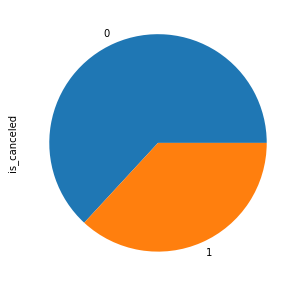

In [43]:
target_train.value_counts(normalize=True).plot(kind='pie', figsize=(5,5))

Наблюдаем дисбаланс 

Просмотрим категориальные признаки для кодирования

In [44]:
features_train.select_dtypes(include='object').head(2)

,arrival_date_month,meal,country,distribution_channel,reserved_room_type,customer_type
0,July,BB,GBR,Direct,A,Transient
1,July,BB,GBR,TA/TO,A,Transient


И кодируем катерогральные признаки

In [46]:
ohe = features_train.select_dtypes(include='object').columns.tolist()
encoder = OneHotEncoder(handle_unknown='ignore', sprase=False)
encoder.fit(features_train[ohe])
features_train_ohe = pd.DataFrame(encoder.transform(features_train[ohe]), columns = encoder.get_feature_names_out(ohe))
features_test_ohe = pd.DataFrame(encoder.transform(features_test[ohe]), columns = encoder.get_feature_names_out(ohe))

ValueError: Shape of passed values is (65073, 1), indices imply (65073, 71)

Масштабируем численные признаки

In [ ]:
features_train.info()

In [ ]:
numeric = features_train.select_dtypes(include=['int64', 'float64']).head(2).columns.tolist()

In [ ]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [ ]:
features_train.head()

Объединим оба получившихся датафрейма

In [ ]:
features_train = features_train.drop(ohe, axis=1)
features_test = features_test.drop(ohe, axis=1)

features_train = pd.concat(
    [features_train_ohe.reset_index(drop=True), features_train.reset_index(drop=True)], 
    axis=1, 
    ignore_index=False
)

features_test = pd.concat(
    [features_test_ohe.reset_index(drop=True), features_test.reset_index(drop=True)], 
    axis=1, 
    ignore_index=False
)

In [ ]:
features_train.head(2)

Данные подготовлены для обучения, начнем проверку моделей, для удобства будем использовать кросс-валидацию

In [ ]:
final_score_best = 0
depth_best = 0

for depth in range(1, 5):
    tree = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=depth, class_weight='balanced')
    scores = cross_val_score(tree, features_train, target_train)
    scores_acc_f1 = cross_val_score(tree, features_train, target_train, scoring='f1')
    scores_acc_roc_auc = cross_val_score(tree, features_train, target_train,scoring='roc_auc')
    final_score = sum(scores) / len(scores)
    if final_score > final_score_best:
        final_score_best = final_score
        depth_best = depth
print('Оценка модели решающего дерева кросс-валидацией:', final_score_best, 'при max_depth =', depth_best)

In [ ]:
scores_acc_f1.mean(), scores_acc_roc_auc.mean()

Оценка модели решающего дерева кросс-валидацией: 0.7692299796412989 при max_depth = 2


Оценка кросс-валидацией: 0.7095271908186467 при n_estimators = 31 при max_depth = 2

Оценка кросс-валидацией: 0.6590281478836498

In [ ]:
tree = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=depth, class_weight='balanced')
tree.fit(features_train, target_train)
prediction_test_tree = tree.predict(features_test)
probabilities_test = tree.predict_proba(features_test)[:, 1]
f1 = f1_score(target_test, prediction_test_tree)
auc_roc = roc_auc_score(target_test, probabilities_test)
       
print('f1-score DecisionTree на тестовой выборке:', f1)
print('roc-auc DecisionTree на тестовой выборке:', auc_roc)

In [ ]:
pd.Series(prediction_test_tree).value_counts()

In [ ]:
data_test['arrival_date_year'].value_counts()

В тестовых данных только данные за 2017 год- удобно будет оценить показатели до ввода модели и после

Подготовим данные из тестовой выборки для расчета прибыли

In [ ]:
data_test['predictions'] = prediction_test_tree
data_test['season_coef'] = data_test.apply(coef, axis=1)
data_test['room_price'] = data_test.apply(room_price, axis=1)
data_test['cleaning_price'] = data_test.apply(cleaning, axis=1)
data_test['profit_without_deposite'] = data_test.apply(profit, axis=1)
data_test.sample(5)


Напишем функцию для подсчета прибыли

In [ ]:
def profit_model(row):
    
    if ((row['is_canceled'] == 0 and row['predictions'] == 1) or 
        (row['is_canceled'] == 0 and row['predictions'] == 0)
       ): # Клиент заселился, модель предсказала, что не заселится либо клиент заселился и модель предсказала, что заселится
        return (row['room_price'] * 
                row['season_coef'] * 
                row['total_nights'] - 
                (1 + row['total_nights'] // 2) * 
                row['cleaning_price']
               )
        
    elif row['is_canceled'] == 1 and row['predictions'] == 0: # Клиент не заселился, но модель предсказала, что заселится 
        return - (row['room_price'] * row['season_coef'] + row['cleaning_price'])
    
    elif row['is_canceled'] == 1 and row['predictions'] == 1: #Клиент не заселился и модель предсказала, что не заселится
        return row['room_price'] * row['season_coef'] * 0.8 + row['cleaning_price']


In [ ]:
data_test['profit_with_deposite'] = data_test.apply(profit_model, axis=1)

In [ ]:
with_deposit = data_test['profit_with_deposite'].sum()

without_deposit = data_test['profit_without_deposite'].sum()

In [ ]:
print(f'Прибыль с применением депозитов: {with_deposit}')
print(f'Прибыль без применения депозитов: {without_deposit}')

In [ ]:
print('Разница в прибыли отеля до и после внедрения депозитов:', 
      with_deposit - without_deposit)

Модель с прогнозом и примененем депозитов приносит больше прибыли. За год окупится с избытком, так как бюджет на разработку 400000.0

### Шаг 5. Опишите портрет «ненадёжного» клиента

In [ ]:
hotel_test_previous_cancel = data_test.groupby('previous_cancellations')['is_canceled']\
.agg(['mean', 'count']).sort_values('mean', ascending=False)
display('Доля отказов от брони в зависимости от количества подтверждённых заказов у клиента ', hotel_test_previous_cancel)

Клиенты, которые бронируют номер впервые, имеют самый высокий процент отказов от брони - 39%


In [ ]:
hotel_test_lead_time = data_test.groupby('lead_time')['is_canceled'].agg(['mean', 'count'])\
.reset_index().sort_values('lead_time', ascending=True)
display('Увеличение вероятности отказа от брони с увеличением времени между бронированием из заездом:',
        hotel_test_lead_time.head(10))
print('')
display('Значение lead_time при вероятности от отказа от брони больше 50%:', hotel_test_lead_time.query('mean > 0.5'))

Чем меньше срок между датой бронирования и датой заезда, тем выше вероятность того, что клиент не отменит бронь;

Вывод:


Самый ненадежный клиент:
Бронирует номер впервые;
Бронирует за срок более 28 дней до даты заезда - вероятность отказа от брони составляет более 50%;
Бронирует за срок более 365 дней до даты заезда - вероятность отказа от брони составляет 100%.


### Шаг 6. Напишите общий вывод

Во время работы над проекто были изучены 2 датафрейма. После чего была произведена предобработка и подготовка данных к машинному обучения. Далее был разработан алгоритм подсчета прибыли или убытка, который приносит клиент, после чего данные были исследованы с использованием кросс-валидации, Дерево решений показало наилучший результат и впоследствии было взято для проверки на тестовой выборке. После чего был получен доход с внесением депозита и получено сравнение с предыдущим результатом, которое показало, что новый подход приносит гораздо больше прибыли и, так как в тестовой выборке данные только за 1 год вложение 400к является выгодной инвестицией. В конце были проанализированы какие критерии наиболее сильно влияют на отмену бронирования и оказалось, что самыми ненадежными клиентами данного отеля являются бронирующие номер впервые, и со сроком более 28 дней
